# Assignment 3

Author: Danis Alukaev <br>
Email: d.alukaev@innopolis.university <br>
Group: B19-DS-01

In this assignment, you will convert GAN and VAE implementations into Conditional GAN and Conditional VAE, respectively: 

Grading:
- Conditional GAN (35 points):
  - Data preprocessing (10 points)
  - Discriminator and Generator (15 points)
  - Training (10 points)
- Conditional VAE (35 points):
  - Data preprocessing (10 points)
  - Encoder and Decoder (15 points)
  - Training (10 points)
- Comparison (15 points):
  - Conditional GAN image generation (5 points)
  - Conditional VAE image generation (5 points)
  - Your opinion which results are better (5 points)
- Metrics and training plots (10 points)
- Clean and documented code (5 points)


Remarks: 

*   Use Fashion MNIST dataset
*   Use Pytorch
*   Cheating will result in 0 points

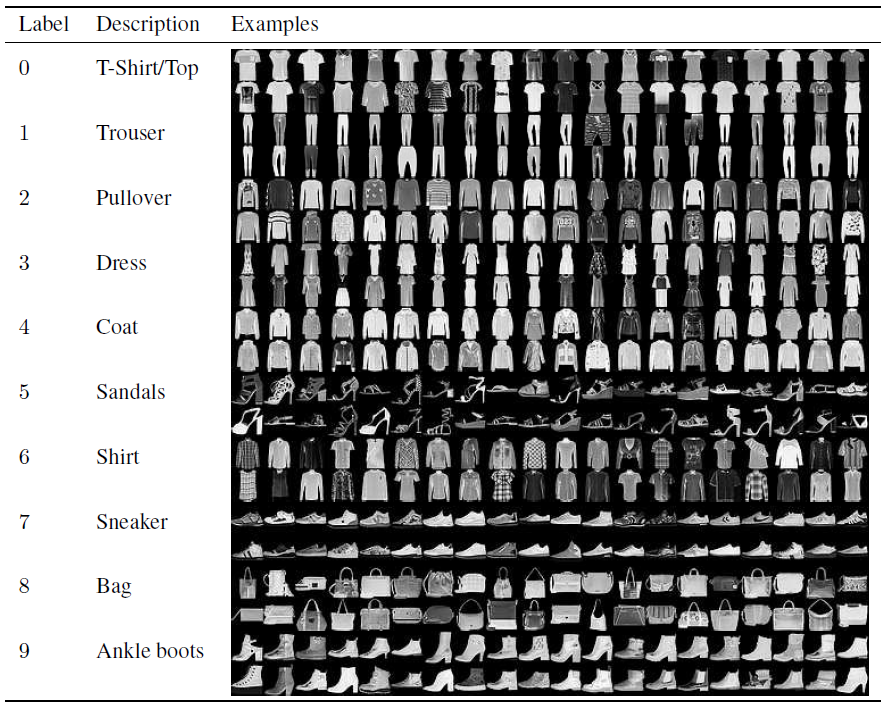

## 0 Prerequisites

### 0.1 Import dependencies

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import pickle as pkl
import torchvision

from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader, random_split

In [2]:
torch.manual_seed(0)

device = "cpu"
if torch.cuda.is_available():
    device = "cuda:0"

### 0.2 Hyperparameters

Generally, it's more convenient to have only one object containing all hyperparameters. For instance, Weights & Biases incorporated such object in their experiment abstraction. Thus, I will implement a simple class `Hyperparameters` that saves keyword arguments as attributes. 

In [3]:
class Hyperparameters:

    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

Following cell is used to configure dataset, cGAN and cVAE.

In [4]:
# Data configuration
dataset_hp = Hyperparameters(
    batch_size=1024,
    shuffle=True,
    num_workers=30,
)

# Conditional GAN configuration
gan_hp = Hyperparameters(
    conv_dim=28,
    z_size=100,
    lr_g=0.002,
    lr_d=0.002,
    adam_beta1=0.5,
    adam_beta2=0.999,
    num_epochs=50,
)

# Conditional VAE configuration
vae_hp = Hyperparameters(
    latent_dims=10,
    lr=1e-3,
    wd=1e-5,
    num_epochs=50,
)

# create nested hyperparameter object
hp = Hyperparameters(
    dataset=dataset_hp,
    gan=gan_hp,
    vae=vae_hp,
)

## 1 Conditional GAN

As a template I will use the GAN implementation from Lab 11.

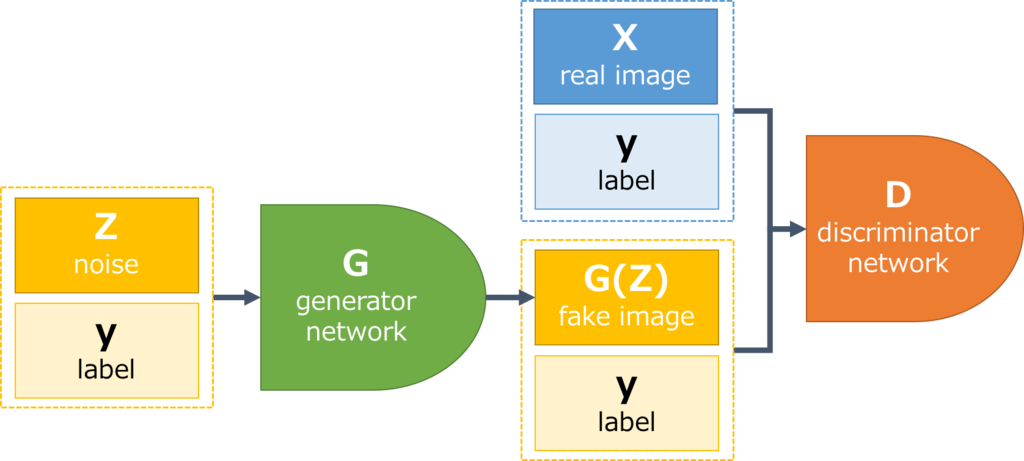

### 1.1 Data

Fortunately, the `torchvision` package already has a class for the Fashion MNIST dataset, so I will use it to construct a dataloader for GAN training.

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

# initialize new instance of Fashion MNIST dataset
fashion_mnist = datasets.FashionMNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

# create a dataloader for the dataset
train_loader = DataLoader(
    dataset=fashion_mnist,
    batch_size=hp.dataset.batch_size,
    shuffle=hp.dataset.shuffle,
    num_workers=hp.dataset.num_workers
)

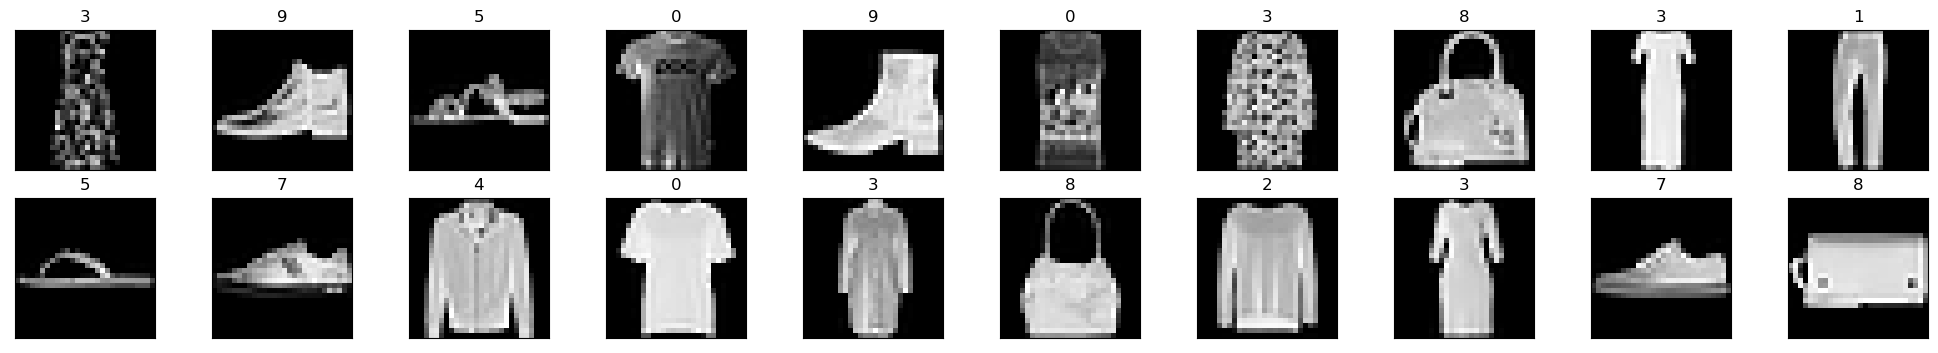

In [6]:
#### TAKEN FROM LAB 11 ####

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size//2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.transpose(images[idx], (1, 2, 0)), cmap="gray")
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

# current range
img = images[0]

In [7]:
#### TAKEN FROM LAB 11 ####

print('Min: ', img.min())
print('Max: ', img.max())

# helper scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min, max = feature_range
    x = x * (max - min) + min
    return x


# scaled range
scaled_img = scale(img)

print('Scaled min: ', scaled_img.min())
print('Scaled max: ', scaled_img.max())

Min:  tensor(0.)
Max:  tensor(0.9961)
Scaled min:  tensor(-1.)
Scaled max:  tensor(0.9922)


### 1.2 Discriminator

In [8]:
#### TAKEN FROM LAB 11 ####

# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False)
    # append conv layer
    layers.append(conv_layer)
    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
    # using Sequential container return the layers
    return nn.Sequential(*layers)

The architecture of discriminator from Lab 11 expects input image to be of shape `(3, 32, 32)`, but samples in Fashion MNIST are of shape `(1, 28, 28)`. 

There are two options: 
1. Resize images to 32x32;
2. Modify convolution layers to comply with new data: <br>
    a. Set default value of `conv_dim` to `16`; <br>
    b. Introduce new argument `in_channels` in constructor with default value of `1`; <br>
    c. Set value of parameter `kernel_size` to `3` in each convolutional layer.

Essentially, we can go with either of these. However, the former option tends to inherit artifacts after the interpolation, so I will stick to the latter alternative.

To condition the discriminator, I will use a trainable embedding of size `(n_classes, img_size x img_size)`. The idea is to learn the semantic of each class, and provide it along with an input image. To do so, for a given label the embedding is reshaped to `(img_size, img_size)` and stacked with input image as a second channel.

In [9]:
class Discriminator(nn.Module):

    def __init__(
        self, 
        conv_dim=16, 
        in_channels=1, 
        img_size=28, 
        n_classes=10,
    ):
        super(Discriminator, self).__init__()
        # current setting for an architecture
        self.conv_dim = conv_dim
        self.in_channels = in_channels
        self.img_size = img_size
        self.n_classes = n_classes

        # embedding to condition discriminator
        self.condition = nn.Embedding(n_classes, img_size * img_size)
        
        ########################## Lab 11 ############################

        # increment number of input channels to fit in the embedding
        self.conv1 = conv(in_channels + 1, conv_dim, kernel_size=3)

        # 3 lines directly taken from source code
        self.conv2 = conv(conv_dim, conv_dim * 2, kernel_size=3)
        self.conv3 = conv(conv_dim * 2, conv_dim * 4, kernel_size=3)
        self.fc = nn.Linear(conv_dim * 4 * 4 * 4, 1)

        ##############################################################

    def forward(self, x, labels):
        # extract the semantic for a given set of labels
        condition = self.condition(labels)
        # reshape embedding to comply with input image
        shade = condition.reshape((-1, 1, self.img_size, self.img_size))
        # stack input image and embedding 
        out = torch.cat([x, shade], dim=1)

        ########################## Lab 11 ############################

        out = F.leaky_relu(self.conv1(out))
        out = F.leaky_relu(self.conv2(out))
        out = F.leaky_relu(self.conv3(out))
        out = out.view(-1, self.conv_dim * 4 * 4 * 4)
        out = self.fc(out)

        ##############################################################

        return out

Let's perform a small sanity check if forward pass works as intended:

In [10]:
x = torch.rand((1, 1, 28, 28))
labels = torch.tensor([0])
Discriminator()(x, labels)

tensor([[-0.3394]], grad_fn=<AddmmBackward0>)

### 1.3 Generator

The implementation of `deconv` method from Lab 11 does not accept `output_padding` as an argument, even though it might help to set up transpose convolutions properly.

In [11]:
#### ADAPTED FROM LAB 11 ####

# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, output_padding=0, batch_norm=True):
    """Creates a transposed-convolutional layer, with optional batch normalization.
    """
    # create a sequence of transpose + optional batch norm layers
    layers = []
    transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, 
                                              kernel_size, stride, padding, output_padding, bias=False)
    # append transpose convolutional layer
    layers.append(transpose_conv_layer)
    
    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

The architecture of generator from Lab 11 produces an image of shape `(3, 32, 32)`, but samples in Fashion MNIST are of shape `(1, 28, 28)`. 

Similar to 1.2, there are two options: 
1. Resize images to 32x32;
2. Modify convolution layers to comply with new data: <br> 
    a. Default value of `conv_dim` is set to `16`; <br>
    b. Introduced new argument `out_channels` in constructor with default value of `1`; <br>
    c. Values of parameter `kernel_size` are set to be `4`, `3`, and `2` in `deconv1`, `deconv2`, and `deconv3`.

Again, I would prefer the latter one.

To condition the generator, I will use a trainable embedding of size `(n_classes, 4 x 4)`. The idea is to learn the semantic of each class, and provide it along with feature map obtained from noise. To do so, for a given label the embedding is reshaped to `(4, 4)` and stacked with output of fully connected layer as a `conv_dim * 4 + 1` channel. Note, that we can concatenate the embedding directly with input noise, but such a trick might lead to mode collapse.

In [12]:
class Generator(nn.Module):
    
    def __init__(
        self, 
        z_size, 
        conv_dim=16, 
        out_channels=1,
        n_classes=10,
    ):
        super(Generator, self).__init__()
        # current setting for an architecture
        self.z_size = z_size
        self.conv_dim = conv_dim
        self.out_channels = out_channels
        self.n_classes = n_classes

        # embedding to condition generator
        self.condition = nn.Embedding(n_classes, 4 * 4)

        ################################ Lab 11 ######################################

        self.fc = nn.Linear(z_size, conv_dim * 4 * 4 * 4)
        # increment number of input channels to fit in embedding
        self.deconv1 = deconv(conv_dim * 4 + 1, conv_dim * 2, kernel_size=4)
        self.deconv2 = deconv(conv_dim * 2, conv_dim, kernel_size=3)
        self.deconv3 = deconv(conv_dim, out_channels, kernel_size=2)

        ##############################################################################

    def forward(self, x, labels):
        out = self.fc(x)
        out = out.view(-1, self.conv_dim * 4, 4, 4)

        # extract the semantic for a given set of labels in a form of feature map
        semantic = self.condition(labels).reshape((-1, 1, 4, 4))
        # stack feature map and embedding 
        out = torch.cat([out, semantic], dim=1)

        out = F.relu(self.deconv1(out))
        out = F.relu(self.deconv2(out))
        out = torch.tanh(self.deconv3(out))

        return out

Let's perform a small sanity check if forward pass works as intended:

In [13]:
Generator(z_size=100)(torch.rand((1, 100)), torch.tensor([0])).shape

torch.Size([1, 1, 28, 28])

### 1.4 Training

For the sake of clarity, I have moved all hyperparameters defined in following cell to the <i>"0. Prerequisites"</i> section.

In [14]:
#### ADAPTED FROM LAB 11 ####

# define params
conv_dim = hp.gan.conv_dim
z_size = hp.gan.z_size

# define discriminator and generator
D = Discriminator(conv_dim)
G = Generator(z_size=z_size, conv_dim=conv_dim)

print(D)
print()
print(G)

train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
    # move models to GPU
    G.cuda()
    D.cuda()
    print('GPU available for training. Models moved to GPU')
else:
    print('Training on CPU.')
    
# hyperparams
lr_d = hp.gan.lr_d
lr_g = hp.gan.lr_g
beta1 = hp.gan.adam_beta1
beta2 = hp.gan.adam_beta2
num_epochs = hp.gan.num_epochs

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr_d, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr_g, [beta1, beta2])

# keep track of loss and generated, "fake" samples
samples = []
losses = []

print_every = 300
sample_size = 16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()
fixed_labels = np.random.randint(low=0, high=10, size=sample_size)
fixed_labels = torch.from_numpy(fixed_labels)

Discriminator(
  (condition): Embedding(10, 784)
  (conv1): Sequential(
    (0): Conv2d(2, 28, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(28, 56, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(56, 112, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(112, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=1792, out_features=1, bias=True)
)

Generator(
  (condition): Embedding(10, 16)
  (fc): Linear(in_features=100, out_features=1792, bias=True)
  (deconv1): Sequential(
    (0): ConvTranspose2d(113, 56, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(56, eps=1e-05, momentum=0.1, 

In [15]:
#### TAKEN FROM LAB 11 ####

def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

The training loop is slightly changed as well. Now we retrieve both images and labels from the batch. These labels are used as an input in discriminator `D` and generator `G`.

In [16]:
#### ADAPTED FROM LAB 11 ####

for epoch in range(num_epochs):
    # retrieve both real_images and real_labels from batch
    for batch_i, (real_images, real_labels) in enumerate(train_loader):
        batch_size = real_images.size(0)
        
        # Rescale images ( 1 line)
        real_images = scale(real_images)
        
        # --------------- TRAIN THE DISCRIMINATOR ---------------
         
        d_optimizer.zero_grad()

        # 1. Train with real images

        # Compute the discriminator losses on real images 
        if train_on_gpu:
            real_images = real_images.cuda()
            real_labels = real_labels.cuda()
        d_real_out = D(real_images, real_labels)
        d_real_loss = real_loss(d_real_out)
        
        # 2. Train with fake images
        
        # Generate fake images  with generator
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()

        if train_on_gpu:
            z = z.cuda()
        fake_images = G(z, real_labels)
        
        # Compute the discriminator losses on fake images 
        d_fake_out = D(fake_images, real_labels)
        d_fake_loss = fake_loss(d_fake_out)           
        
        # Add up loss and perform backprop
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        # --------------- TRAIN THE GENERATOR ---------------

        g_optimizer.zero_grad()
        
        # 1. Train with fake images and flipped labels
    
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        if train_on_gpu:
            z = z.cuda()
        fake_images = G(z, real_labels)
        
        # Compute the discriminator losses on fake images 
        d_fake_out = D(fake_images, real_labels)
        g_loss = real_loss(d_fake_out)
  
        # Perform backprop
        g_loss.backward()
        g_optimizer.step()

        # -------------------- STATS --------------------

        if batch_i % print_every == 0:
            # append discriminator loss and generator loss
            losses.append((d_loss.item(), g_loss.item()))
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    ## AFTER EACH EPOCH##    
    # generate and save sample, fake images
    G.eval() # for generating samples
    if train_on_gpu:
        fixed_z = fixed_z.cuda()
        fixed_labels = fixed_labels.cuda()
    samples_z = G(fixed_z, fixed_labels)
    samples.append(samples_z)
    G.train() # back to training mode

# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch [    1/   50] | d_loss: 1.4693 | g_loss: 2.1600
Epoch [    2/   50] | d_loss: 2.3888 | g_loss: 4.5000
Epoch [    3/   50] | d_loss: 0.7150 | g_loss: 1.7040
Epoch [    4/   50] | d_loss: 1.6158 | g_loss: 4.2274
Epoch [    5/   50] | d_loss: 0.7933 | g_loss: 1.8883
Epoch [    6/   50] | d_loss: 0.7698 | g_loss: 1.3711
Epoch [    7/   50] | d_loss: 0.7158 | g_loss: 1.5543
Epoch [    8/   50] | d_loss: 0.7071 | g_loss: 1.9019
Epoch [    9/   50] | d_loss: 0.6476 | g_loss: 2.5499
Epoch [   10/   50] | d_loss: 0.7833 | g_loss: 1.2431
Epoch [   11/   50] | d_loss: 0.6956 | g_loss: 3.1620
Epoch [   12/   50] | d_loss: 0.5290 | g_loss: 2.2289
Epoch [   13/   50] | d_loss: 1.1208 | g_loss: 4.5519
Epoch [   14/   50] | d_loss: 1.1465 | g_loss: 3.7539
Epoch [   15/   50] | d_loss: 0.5921 | g_loss: 1.6208
Epoch [   16/   50] | d_loss: 0.5714 | g_loss: 1.5411
Epoch [   17/   50] | d_loss: 0.5832 | g_loss: 1.3946
Epoch [   18/   50] | d_loss: 0.6084 | g_loss: 3.1524
Epoch [   19/   50] | d_loss

Let's now visualize losses of cGAN throghout the training process.

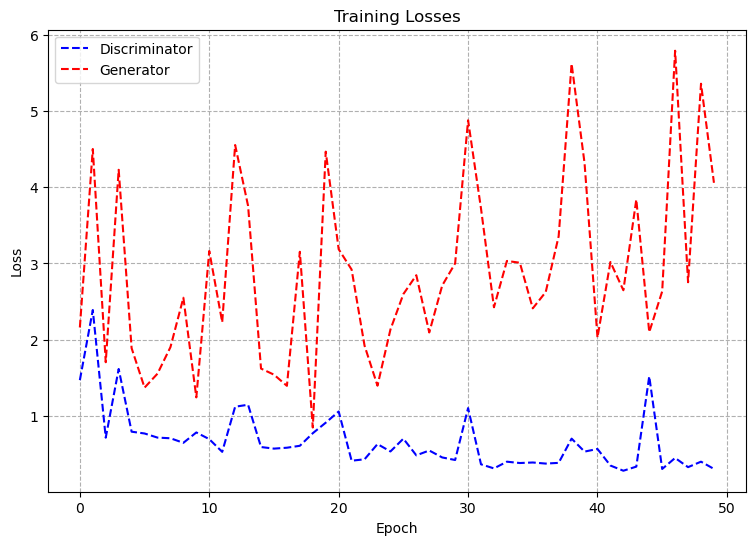

In [17]:
def plot_gan_losses(losses):
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(9, 6)
    ax1.set_title(f"Training Losses")
    ax1.grid(linestyle='--')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.plot([x[0] for x in losses], '--', label='Discriminator', c='b')
    ax1.plot([x[1] for x in losses], '--', label='Generator', c='r')
    ax1.legend()
    plt.show()

plot_gan_losses(losses)

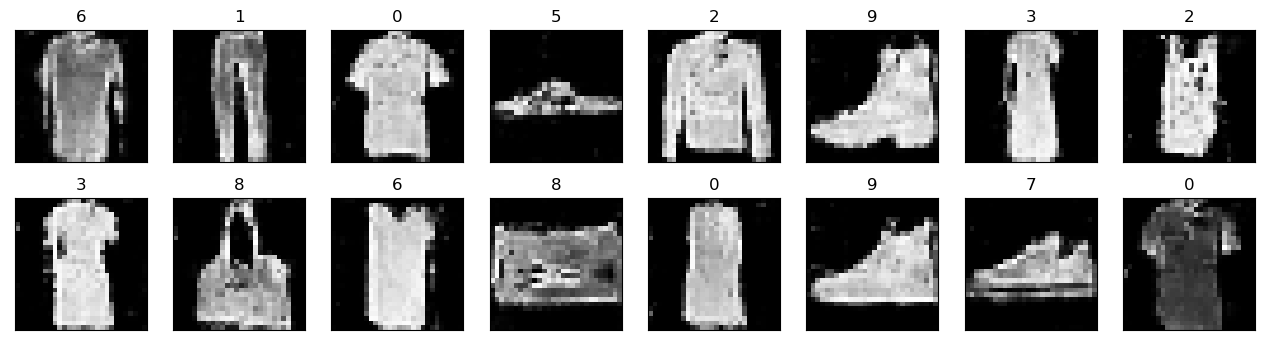

In [18]:
#### ADAPTED FROM LAB 11 ####

# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for idx, (ax, img) in enumerate(zip(axes.flatten(), samples[epoch])):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img +1)*255 / (2)).astype(np.uint8) # rescale to pixel range (0-255)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28, 28, 1)), cmap="gray")
        ax.set_title(str(fixed_labels[idx].item()))

_ = view_samples(-1, samples)

On inference it will be handy to have an object that generates an image for a given list of labels. In following cell I define such a class that might be useful in section 3.

In [19]:
class ImageGeneratorGAN:

    def __init__(self, model):
        self.model = model
        self.name = "GAN"

    def __call__(self, labels):
        # prepare model and input labels for inference
        self.model.eval().cpu()
        labels_ = torch.tensor(labels)
        
        # produce set of random noises for each label
        z = torch.from_numpy(np.random.uniform(-1, 1, size=(len(labels), z_size))).float()

        # generate images
        images = self.model(z, labels_)

        # process images so that they can be visualized properly
        images = images.detach().cpu().numpy()
        images = np.transpose(images, (0, 2, 3, 1))
        images = ((images + 1) * 255 / (2)).astype(np.uint8)

        return images, labels

In [20]:
image_generator_gan = ImageGeneratorGAN(G)

In [21]:
image, label = image_generator_gan([7])
print(image.shape, label)

(1, 28, 28, 1) [7]


## 2 Conditional Variational Autoencoder

Conditional VAE implementation was based on source code of VAE provided in Assignment specification.

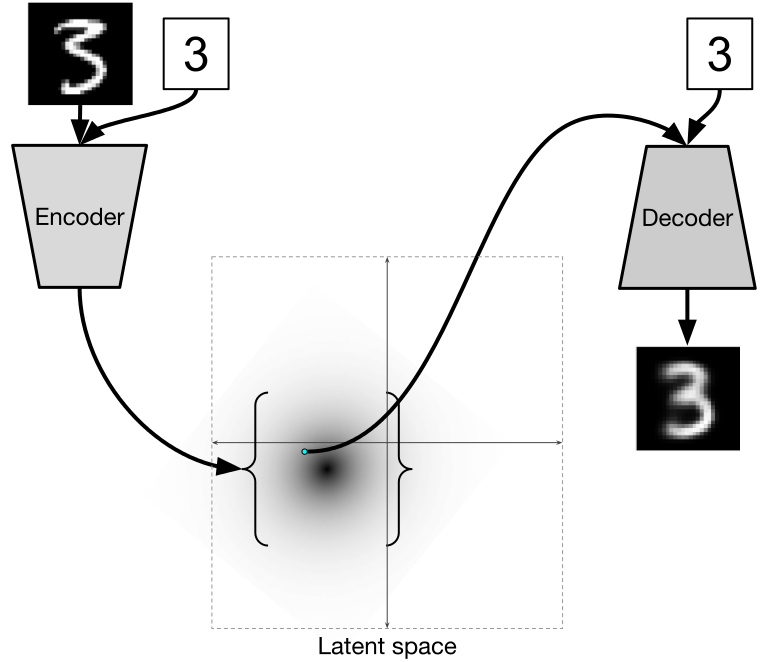

### 2.1 Data

The following cell is quite similar to the section 1.1. The minor difference is random splitting of a dataset into train, test, and validation partitions. This is required by a source code we have to stick in this assignment.

In [22]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

# initialize new instance of Fashion MNIST dataset
fashion_mnist = datasets.FashionMNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

# split dataset into three partitions (it is required in source code)
train_dataset, valid_dataset, test_dataset = random_split(fashion_mnist, [45000, 10000, 5000])

# create a dataloaders for obtained partitions
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=hp.dataset.batch_size,
    shuffle=hp.dataset.shuffle,
    num_workers=hp.dataset.num_workers
)

valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=hp.dataset.batch_size,
    shuffle=hp.dataset.shuffle,
    num_workers=hp.dataset.num_workers
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=hp.dataset.batch_size,
    shuffle=hp.dataset.shuffle,
    num_workers=hp.dataset.num_workers
)

### 2.2 Encoder

The encoder conditioned similar to 1.2, i.e., by using a trainable embedding of size `(n_classes, img_size x img_size)`. The idea is to learn the semantic of each class, and provide it along with an input image. To do so, for a given label the embedding is reshaped to `(img_size, img_size)` and stacked with input image as a second channel.

In [23]:
class VariationalEncoder(nn.Module):
    def __init__(
        self, 
        latent_dims,
        n_classes=10,
        img_size=28,
    ):  
        super(VariationalEncoder, self).__init__()
        # current setting for an architecture
        self.latent_dims = latent_dims
        self.n_classes = n_classes
        self.img_size = img_size

        # embedding to condition discriminator
        self.condition = nn.Embedding(n_classes, img_size * img_size)

        ########################## SOURCE CODE ##########################

        # increment number of input channels to fit in the embedding
        self.conv1 = nn.Conv2d(2, 8, 3, stride=2, padding=1)
        
        self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=1)
        self.batch2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3, stride=2, padding=0)  
        self.linear1 = nn.Linear(3 * 3 * 32, 128)
        self.linear2 = nn.Linear(128, latent_dims)
        self.linear3 = nn.Linear(128, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

        #################################################################

    def forward(self, x, labels):
        # extract the semantic for a given set of labels
        condition = self.condition(labels)
        # reshape embedding to comply with input image
        shade = condition.reshape((-1, 1, self.img_size, self.img_size))
        # stack input image and embedding 
        x = torch.cat([x, shade], dim=1)

        ########################## SOURCE CODE ##########################

        x = x.to(device)
        x = F.relu(self.conv1(x))
        x = F.relu(self.batch2(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu = self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma * self.N.sample(mu.shape)
        self.kl = (sigma ** 2 + mu ** 2 - torch.log(sigma) - 1 / 2).sum()

        #################################################################

        return z      

Let's perform a small sanity check if forward pass works as intended:

In [24]:
x = torch.rand((1, 1, 28, 28)).cuda()
labels = torch.tensor([0]).cuda()
_ = VariationalEncoder(latent_dims=10).cuda()
_(x, labels)

tensor([[-0.8095, -0.4920, -2.6607,  0.1515,  0.0106, -0.6209, -0.5371, -0.2521,
         -1.1325, -0.1876]], device='cuda:0', grad_fn=<AddBackward0>)

### 2.3 Decoder

The decoder is conditioned different from 1.3. Here I am using a trainable embedding of size `(n_classes, latent_dims)`. The idea is to learn the semantic of each class, and provide it along with input latent vector. To do so, for a given label the embedding is concatenated with an input tensor `x` resulting in `latent_dims * 2` vector. Note, that we can stack the embedding with feature map produced by `self.unflatten`, but such a trick might lead to unstable training.

In [25]:
class Decoder(nn.Module):
    def __init__(
        self, 
        latent_dims,
        n_classes=10,
    ):
        super().__init__()
        # current setting for an architecture
        self.latent_dims = latent_dims
        self.n_classes = n_classes

        # embedding to condition generator
        self.condition = nn.Embedding(n_classes, latent_dims)
        
        ########################## SOURCE CODE ##########################

        self.decoder_lin = nn.Sequential(
            # increase input size of linear layer twice to fit in embedding
            nn.Linear(latent_dims * 2, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )

        #################################################################
        
    def forward(self, x, labels):
        # extract the semantic for a given set of labels
        semantic = self.condition(labels)
        # stack input latent vector and embedding
        x = torch.cat([x, semantic], dim=1)

        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

Let's perform a small sanity check if forward pass works as intended:

In [26]:
Decoder(latent_dims=10)(torch.rand((1, 10)), torch.tensor([0])).shape

torch.Size([1, 1, 28, 28])

### 2.4 Training

The forward pass of variational autoencoder is now taking `labels` as argument, which is further used by encoder and decoder.  

In [27]:
#### ADAPTED FROM SOURCE CODE ####

class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x, labels):
        # input labels in both encoder and decoder
        x = x.to(device)
        labels = labels.to(device)
        z = self.encoder(x, labels)
        return self.decoder(z, labels)

For the sake of clarity, I have moved all hyperparameters defined in following cell to the <i>"0. Prerequisites"</i> section.

In [28]:
#### ADAPTED FROM SOURCE CODE ####

vae = VariationalAutoencoder(latent_dims=hp.vae.latent_dims)

optim = torch.optim.Adam(vae.parameters(), lr=hp.vae.lr, weight_decay=hp.vae.wd)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

vae.to(device)

Selected device: cuda


VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (condition): Embedding(10, 784)
    (conv1): Conv2d(2, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (batch2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (linear1): Linear(in_features=288, out_features=128, bias=True)
    (linear2): Linear(in_features=128, out_features=10, bias=True)
    (linear3): Linear(in_features=128, out_features=10, bias=True)
  )
  (decoder): Decoder(
    (condition): Embedding(10, 10)
    (decoder_lin): Sequential(
      (0): Linear(in_features=20, out_features=128, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=128, out_features=288, bias=True)
      (3): ReLU(inplace=True)
    )
    (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
    (decoder_conv): Sequential(
      (0): Co

The training and testing loops are slightly changed as well. Now we retrieve both images and labels from the batch. These labels are used as an input in variational autoencoder.

In [29]:
#### ADAPTED FROM SOURCE CODE ####

### Training function
def train_epoch(vae, device, dataloader, optimizer):
    # Set train mode for both the encoder and the decoder
    vae.train()
    train_loss = 0.0
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for x, labels in dataloader: 
        # Move tensors to the proper device
        x = x.to(device)
        labels = labels.to(device)
        x_hat = vae(x, labels)
        # Evaluate loss
        loss = ((x - x_hat)**2).sum() + vae.encoder.kl
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        # print('\t partial train loss (single batch): %f' % (loss.item()))
        train_loss+=loss.item()

    return train_loss / len(dataloader.dataset)

In [30]:
#### ADAPTED FROM SOURCE CODE ####

### Testing function
def test_epoch(vae, device, dataloader):
    # Set evaluation mode for encoder and decoder
    vae.eval()
    val_loss = 0.0
    with torch.no_grad(): # No need to track the gradients
        for x, labels in dataloader:
            # Move tensors to the proper device
            x = x.to(device)
            labels = labels.to(device)
            # Encode data
            encoded_data = vae.encoder(x, labels)
            # Decode data
            x_hat = vae(x, labels)
            loss = ((x - x_hat)**2).sum() + vae.encoder.kl
            val_loss += loss.item()

    return val_loss / len(dataloader.dataset)

In [31]:
#### ADAPTED FROM SOURCE CODE ####

def plot_ae_outputs(encoder, decoder, n=10):
    plt.figure(figsize=(16,4.5))
    targets = np.array([int(s[1]) for s in test_dataset]) 
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = test_dataset[t_idx[i]][0].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
        # input labels along with images and latent vectors
        rec_img = decoder(encoder(img, torch.tensor([i]).to(device)), torch.tensor([i]).to(device))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()  


 EPOCH 1/50 	 train loss 100.912 	 val loss 84.617


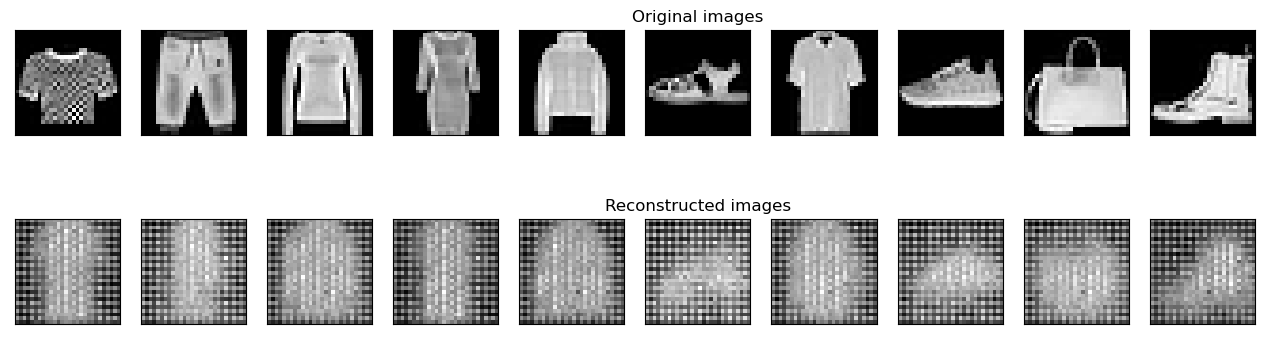


 EPOCH 2/50 	 train loss 71.003 	 val loss 60.274

 EPOCH 3/50 	 train loss 55.626 	 val loss 49.476

 EPOCH 4/50 	 train loss 45.880 	 val loss 42.293

 EPOCH 5/50 	 train loss 40.045 	 val loss 37.778

 EPOCH 6/50 	 train loss 36.345 	 val loss 34.812

 EPOCH 7/50 	 train loss 33.822 	 val loss 32.695

 EPOCH 8/50 	 train loss 32.079 	 val loss 31.427

 EPOCH 9/50 	 train loss 30.890 	 val loss 30.375

 EPOCH 10/50 	 train loss 30.052 	 val loss 29.595

 EPOCH 11/50 	 train loss 29.382 	 val loss 29.282


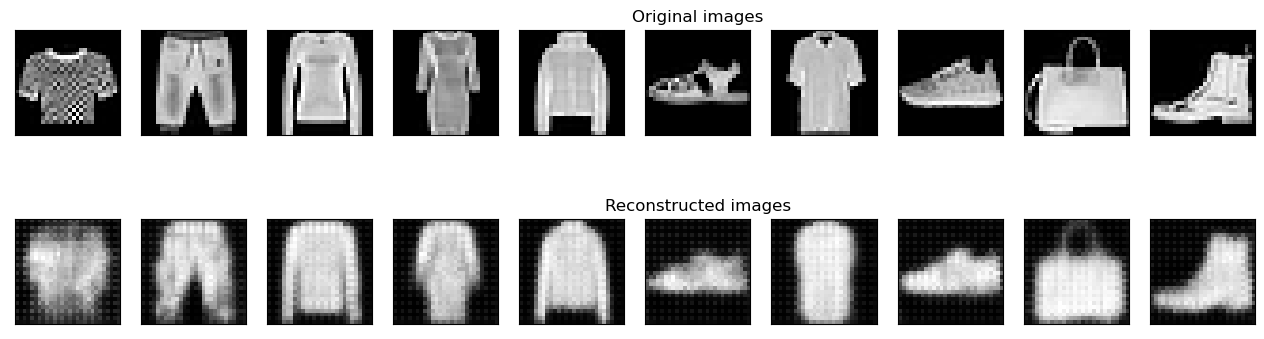


 EPOCH 12/50 	 train loss 28.895 	 val loss 28.592

 EPOCH 13/50 	 train loss 28.437 	 val loss 28.314

 EPOCH 14/50 	 train loss 28.130 	 val loss 27.936

 EPOCH 15/50 	 train loss 27.837 	 val loss 27.707

 EPOCH 16/50 	 train loss 27.654 	 val loss 27.563

 EPOCH 17/50 	 train loss 27.404 	 val loss 27.317

 EPOCH 18/50 	 train loss 27.197 	 val loss 27.126

 EPOCH 19/50 	 train loss 27.050 	 val loss 26.946

 EPOCH 20/50 	 train loss 26.945 	 val loss 26.879

 EPOCH 21/50 	 train loss 26.775 	 val loss 26.727


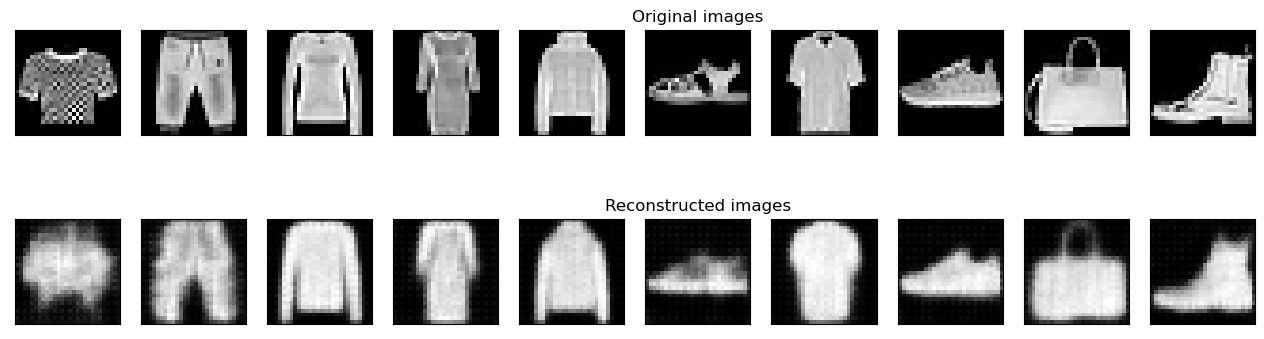


 EPOCH 22/50 	 train loss 26.681 	 val loss 26.689

 EPOCH 23/50 	 train loss 26.563 	 val loss 26.514

 EPOCH 24/50 	 train loss 26.476 	 val loss 26.474

 EPOCH 25/50 	 train loss 26.391 	 val loss 26.416

 EPOCH 26/50 	 train loss 26.411 	 val loss 26.334

 EPOCH 27/50 	 train loss 26.239 	 val loss 26.375

 EPOCH 28/50 	 train loss 26.195 	 val loss 26.112

 EPOCH 29/50 	 train loss 26.106 	 val loss 26.297

 EPOCH 30/50 	 train loss 26.081 	 val loss 26.226

 EPOCH 31/50 	 train loss 26.037 	 val loss 25.947


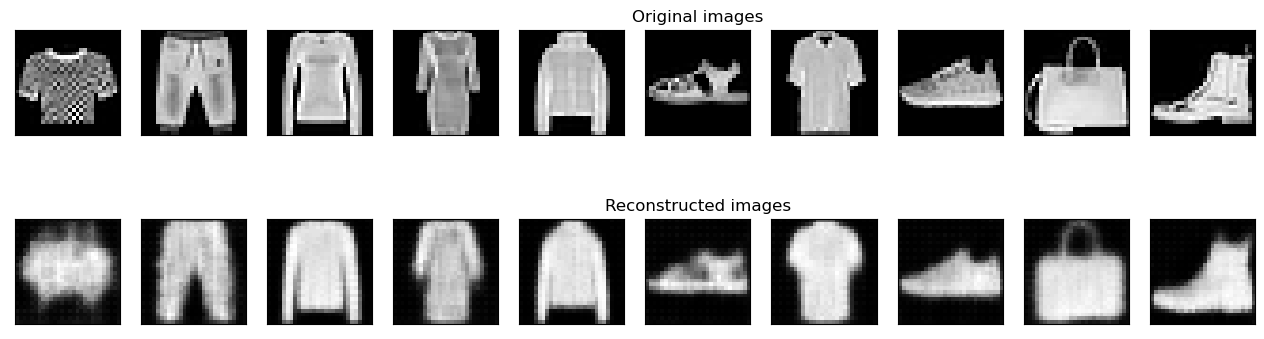


 EPOCH 32/50 	 train loss 25.942 	 val loss 25.917

 EPOCH 33/50 	 train loss 25.932 	 val loss 25.921

 EPOCH 34/50 	 train loss 25.881 	 val loss 25.913

 EPOCH 35/50 	 train loss 25.839 	 val loss 25.933

 EPOCH 36/50 	 train loss 25.802 	 val loss 25.869

 EPOCH 37/50 	 train loss 25.768 	 val loss 25.751

 EPOCH 38/50 	 train loss 25.707 	 val loss 25.703

 EPOCH 39/50 	 train loss 25.706 	 val loss 25.667

 EPOCH 40/50 	 train loss 25.617 	 val loss 25.654

 EPOCH 41/50 	 train loss 25.639 	 val loss 25.763


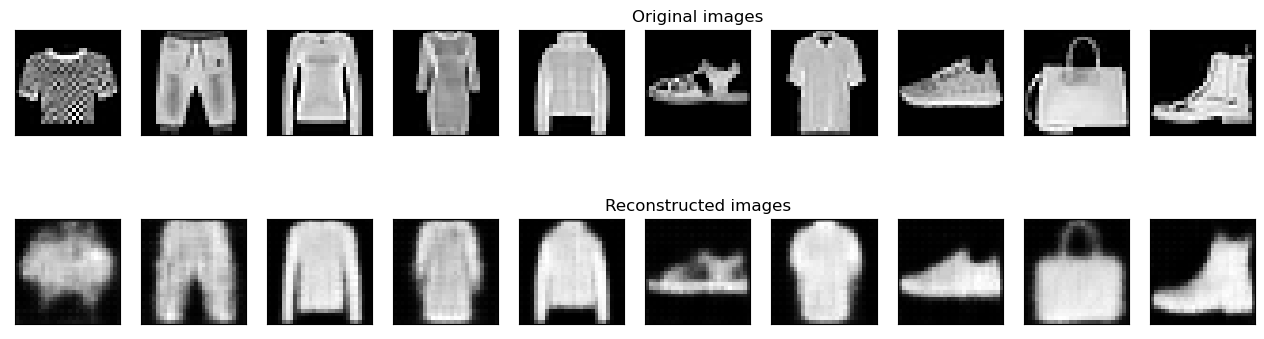


 EPOCH 42/50 	 train loss 25.631 	 val loss 25.622

 EPOCH 43/50 	 train loss 25.573 	 val loss 25.666

 EPOCH 44/50 	 train loss 25.577 	 val loss 25.606

 EPOCH 45/50 	 train loss 25.546 	 val loss 25.569

 EPOCH 46/50 	 train loss 25.472 	 val loss 25.506

 EPOCH 47/50 	 train loss 25.481 	 val loss 25.588

 EPOCH 48/50 	 train loss 25.474 	 val loss 25.522

 EPOCH 49/50 	 train loss 25.422 	 val loss 25.477

 EPOCH 50/50 	 train loss 25.391 	 val loss 25.454


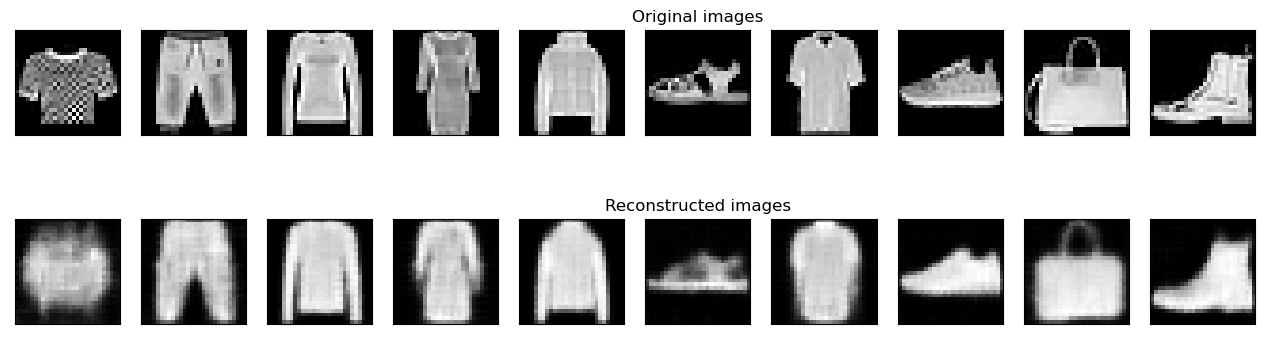

In [32]:
num_epochs = hp.vae.num_epochs
plot_each = 10

losses = dict(
   train=list(),
   val=list(),
)

for epoch in range(num_epochs):
   train_loss = train_epoch(vae, device, train_loader, optim)
   val_loss = test_epoch(vae, device, valid_loader)
   losses["train"].append(train_loss)
   losses["val"].append(val_loss)
   print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   if epoch % plot_each == 0:
      plot_ae_outputs(vae.encoder, vae.decoder, n=10)
plot_ae_outputs(vae.encoder, vae.decoder, n=10)

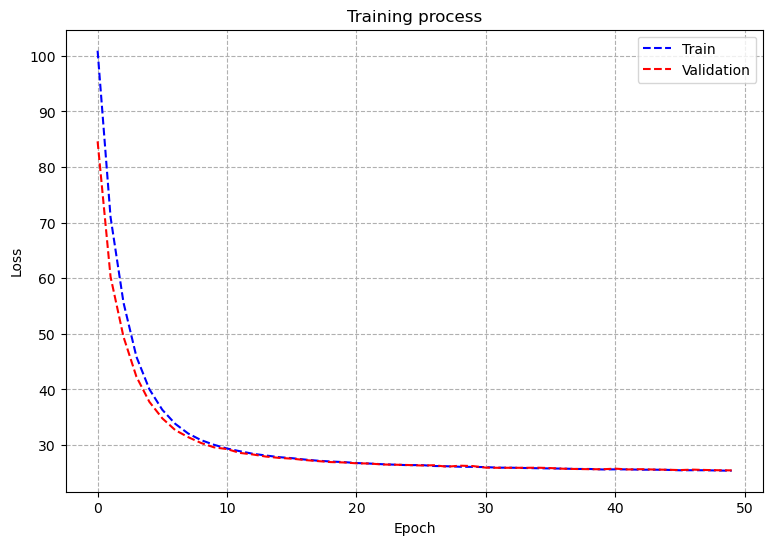

In [33]:
def plot_vae_losses(losses):
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(9, 6)
    ax1.set_title(f"Training process")
    ax1.grid(linestyle='--')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.plot(np.arange(len(losses['train'])), np.array(losses['train']), '--', label='Train', c='b')
    ax1.plot(np.arange(len(losses['val'])), np.array(losses['val']), '--', label='Validation', c='r')
    ax1.legend()
    plt.show()

plot_vae_losses(losses)

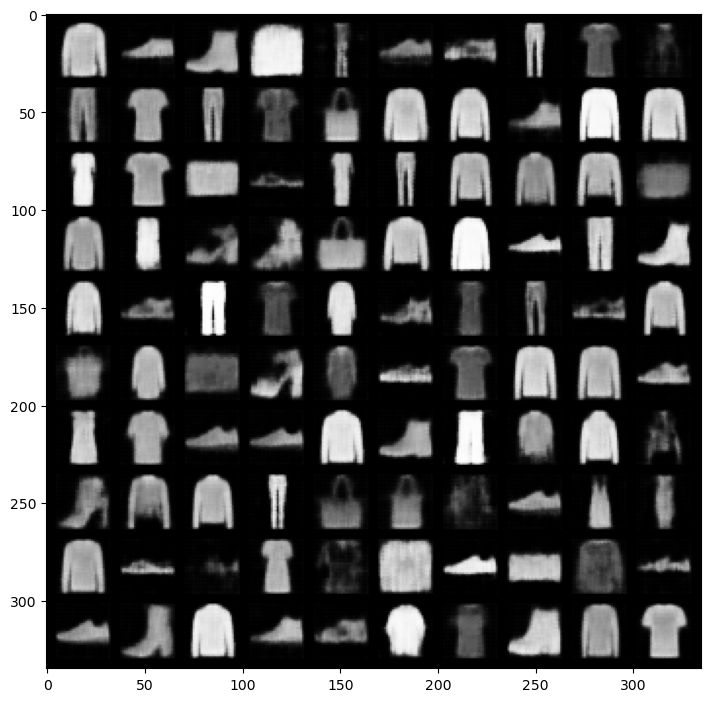

In [34]:
#### ADAPTED FROM SOURCE CODE ####

def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

vae.eval()

with torch.no_grad():
    # sample latent vectors from the normal distribution
    latent = torch.randn(128,  hp.vae.latent_dims, device=device)
    # generate set of labels to condition the VAE
    labels = torch.randint(low=0, high=10, size=(128,), device=device)

    # reconstruct images from the latent vectors
    img_recon = vae.decoder(latent, labels)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(20, 8.5))
    show_image(torchvision.utils.make_grid(img_recon.data[:100],10,5))
    plt.show()

On inference it will be handy to have an object that generates an image for a given list of labels. In following cell I define such a class that might be useful in section 3.

In [35]:
class ImageGeneratorVAE:

    def __init__(self, model):
        self.model = model
        self.name = "VAE"

    def __call__(self, labels):
        # prepare model and input labels for inference
        self.model.eval().cpu()
        labels_ = torch.tensor(labels)

        # produce set of latent vectors
        latent = torch.randn(len(labels),  self.model.latent_dims)

        # generate images
        images = self.model(latent, labels_)

        # process images so that they can be visualized properly
        images = images.detach().cpu().numpy()
        images = np.transpose(images, (0, 2, 3, 1))

        return images, labels

In [36]:
image_generator_vae = ImageGeneratorVAE(vae.decoder)

In [37]:
image, label = image_generator_vae([7])
print(image.shape, label)

(1, 28, 28, 1) [7]


# 3 Comparison
Generate images of given labels using both Conditional GAN and Conditional VAE models that you trained. Write your opinion which model is better.

In [38]:
classes = {0: "T-shirt/Top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat", 5: "Sandals", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boots"}

In [39]:
def plot_images(method, labels=list(range(10)), n_instances=2):
    for label in labels:
        images, _ = method([label] * n_instances)
        fig, axes = plt.subplots(1, n_instances)
        fig.suptitle(f"{label}: {classes[label]}")
        for idx, image in enumerate(images):
            fig.set_size_inches(n_instances * 3, 3)
            image = axes[idx].imshow(image, cmap="gray")
            axes[idx].get_xaxis().set_visible(False)
            axes[idx].get_yaxis().set_visible(False) 

### 3.1 Conditional GAN
Generate two images of each class from Fashion MNIST dataset using your Conditional GAN model

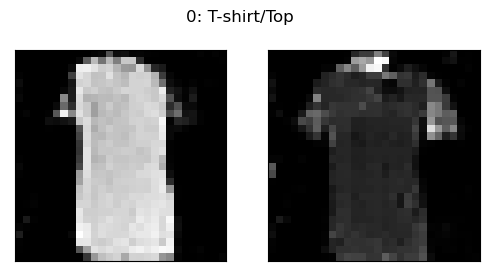

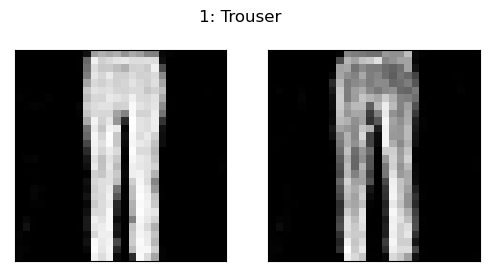

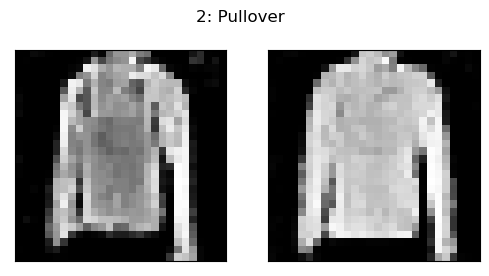

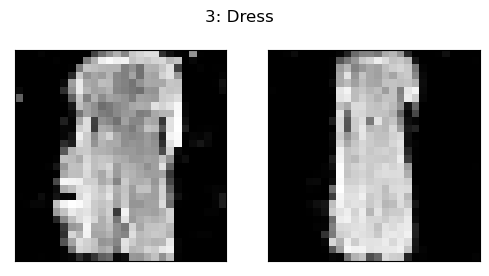

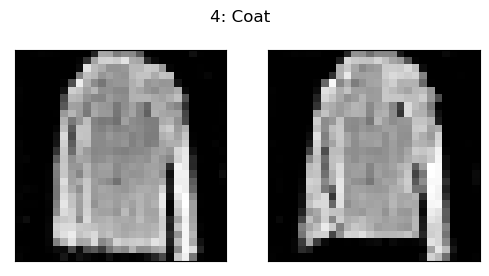

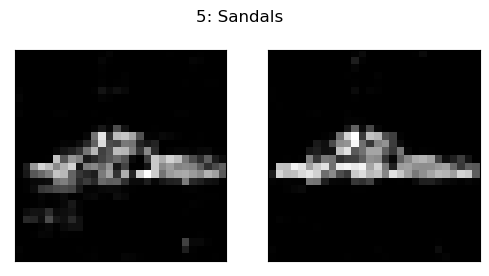

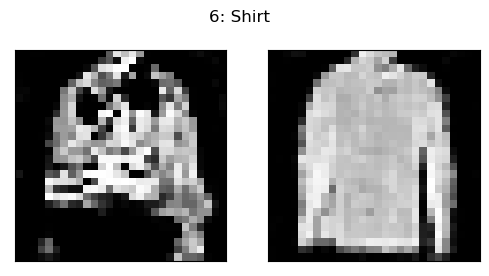

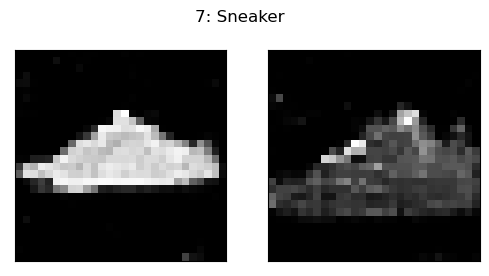

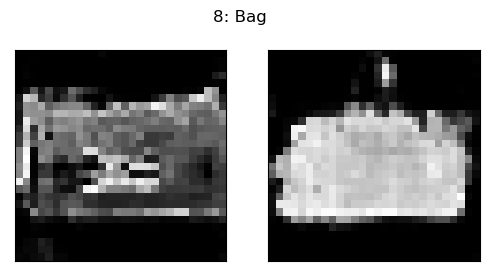

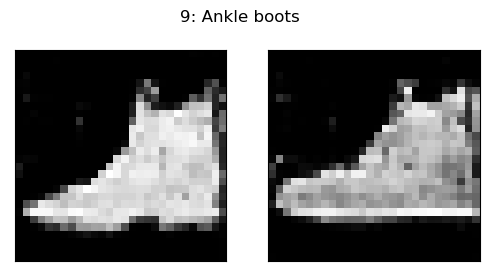

In [40]:
plot_images(image_generator_gan)

### 3.2 Conditional VAE
Generate two images of each class from Fashion MNIST dataset using your Conditional VAE model

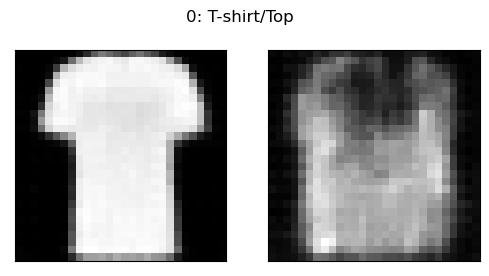

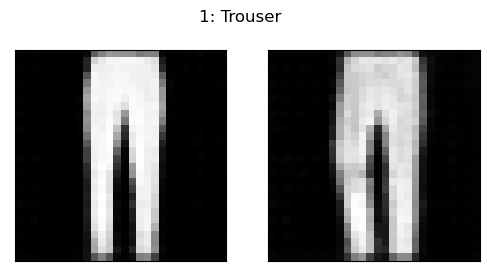

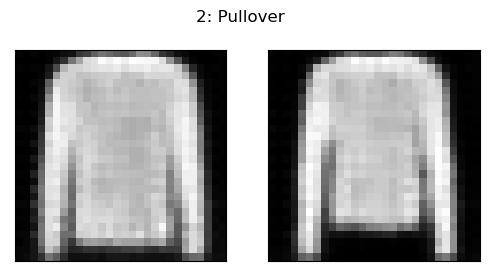

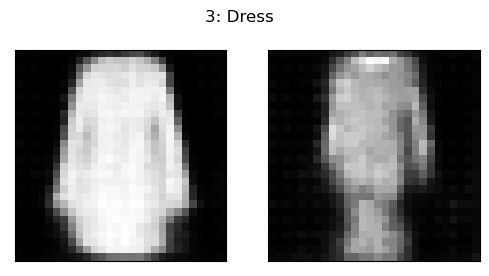

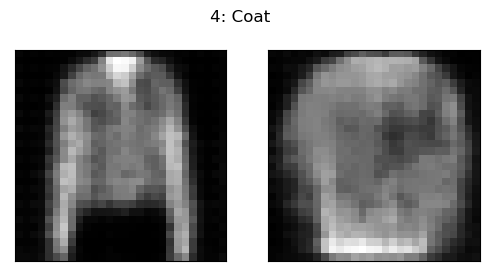

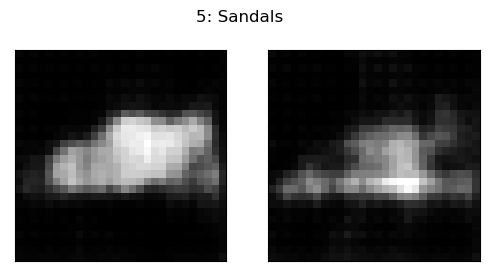

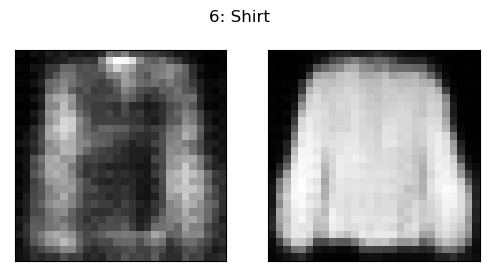

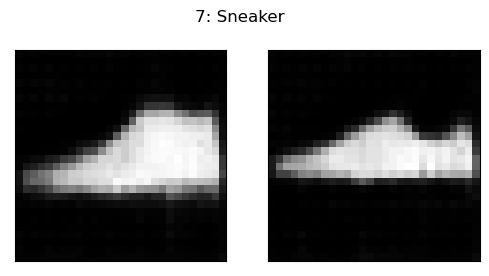

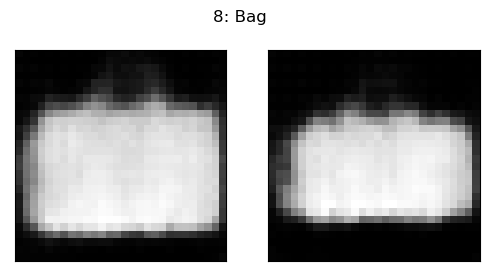

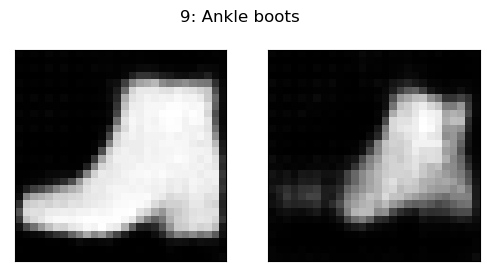

In [41]:
plot_images(image_generator_vae)

### 3.3 My opinion

As you can see from 3.1 and 3.2 both models produce images of a moderate quality. Although GAN prone to mode collapse, I managed to retain a decent level of diversity in generated images. 

Note that whereas cGAN aims to generate realistic images with distinct textures, the cVAE is trying to capture the shape of an item. I hereby declare that applications of these two architectures depends on a task. In case you want to create indeed new image, the obvious choice is cGAN. On contrary, if your goal is exploration different variations of item's design to perhaps refine it, I would suggest using cVAE.

Frankly speaking, we cannot say which architecture is potentially better. Apparently, it is crucial to optimize hyperparameters and fine-tune models on larger dataset. However, I personally think that the results obtained using cGAN model tends to be superior due to their photo-realism.

# References

* [Synthetic Data Generation Using Conditional-GAN](https://towardsdatascience.com/synthetic-data-generation-using-conditional-gan-45f91542ec6b)

* [Generating synthetic tabular data with GANs](https://medium.com/ydata-ai/generating-synthetic-tabular-data-with-gans-part-2-a0aba150539)

* [Understanding Conditional Variational Autoencoders](https://theaiacademy.blogspot.com/2020/05/understanding-conditional-variational.html)

* [Understanding Variational Autoencoders (VAEs)](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73)

* [Intuitively Understanding Variational Autoencoders](https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf)

* [Tutorial - What is a variational autoencoder?](https://jaan.io/what-is-variational-autoencoder-vae-tutorial/)

* [The variational auto-encoder](https://ermongroup.github.io/cs228-notes/extras/vae/)

* [An Introduction to Variational Autoencoders](https://arxiv.org/abs/1906.02691)

* [Basic VAE Example](https://github.com/pytorch/examples/tree/master/vae)

* [Deep Convolutional Generative Adversarial Network](https://www.tensorflow.org/tutorials/generative/dcgan)

* [Generative adversarial networks: What GANs are and how they’ve evolved](https://venturebeat.com/2019/12/26/gan-generative-adversarial-network-explainer-ai-machine-learning/)

* [Generative Adversarial Nets](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf)

* [GANs by google](https://developers.google.com/machine-learning/gan)

* [A Gentle Introduction to Generative Adversarial Networks (GANs)](https://machinelearningmastery.com/what-are-generative-adversarial-networks-gans/)

* [A Beginner's Guide to Generative Adversarial Networks (GANs)](https://pathmind.com/wiki/generative-adversarial-network-gan)

* [Understanding Generative Adversarial Networks (GANs)](https://towardsdatascience.com/understanding-generative-adversarial-networks-gans-cd6e4651a29)

* [Deep Learning (PyTorch)](https://github.com/udacity/deep-learning-v2-pytorch)

* [10 Lessons I Learned Training GANs for one Year](https://towardsdatascience.com/10-lessons-i-learned-training-generative-adversarial-networks-gans-for-a-year-c9071159628)

* [GAN(Generative Adversarial Networks) и tensorflow (Russian)](https://habr.com/ru/post/332000/)

* [Conditional VAE (Russian)](https://habr.com/ru/post/331664/)